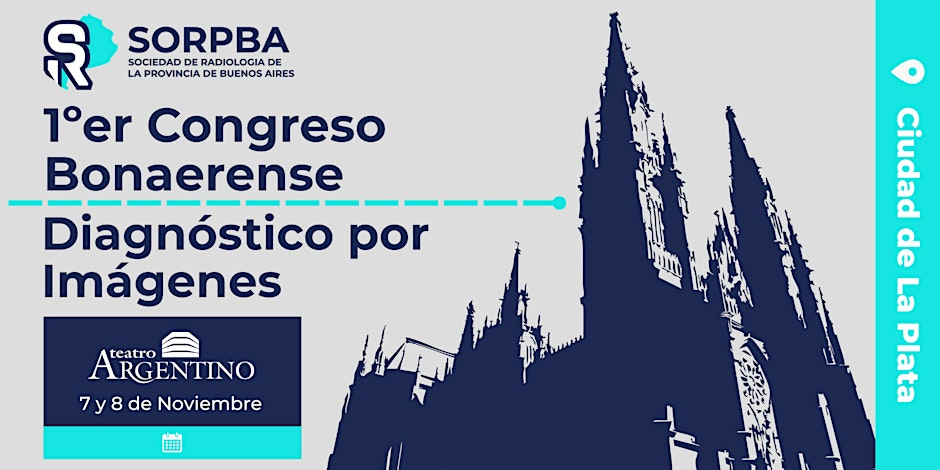

# Taller IA SORPBA 2025 - IA Práctica. Aprender Haciendo.

- Haremos una tarea de Clasificación de Imágenes, de principio a fin.

- Utilizaremos una versión del DataSet MedNIST, basado en TCIA, RSNA Bone Age Challenge, y NIH Chest X-ray dataset.

`El dataset disponible gracias al Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic), con licencia Creative Commons CC BY-SA 4.0.
El código se basa en lo descripto en  https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb, donde se encuentra el acceso a dicho dataset.`

In [ ]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [ ]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2
import ipywidgets as widgets
from IPython.display import clear_output
from google.colab import files


from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism



In [ ]:
!gdown https://drive.google.com/uc?id=19HvIeOPWIEixqFaZmjtf90tGMU5cx4E4 -O modelo_entrenado.pth

In [ ]:
# @title
class MedNISTDataset(Dataset):
    def __init__(self, imagenesArch, etiquetas, transformaciones):
        self.imagenesArch = imagenesArch
        self.etiquetas = etiquetas
        self.transformaciones = transformaciones

    def __len__(self):
        return len(self.imagenesArch)

    def __getitem__(self, indice):
        return self.transformaciones(self.imagenesArch[indice]), self.etiquetas[indice]


In [ ]:
##########################################################################################################################################
dispositivoProcesador = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelo = DenseNet121(
    spatial_dims=2,
    in_channels=1,
    out_channels=6
).to(dispositivoProcesador)


##########################################################################################################################################

## Prueba del Modelo con una Imagen.
Vamos a poner a prueba el modelo con una imagen cualquiera vinculada a las clases que hemos visto, para ver si el modelo logra clasificarla correctamente.
La imagen la cargaremos en nuestro Drive.

In [ ]:
transformacionesValidacion = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    ToTensor()
])

In [ ]:
# @title
def preprocesamientoImagenPrueba(imagenArchivo):
  imagen = PIL.Image.open(imagenArchivo).convert('L')
  imagen64x64 = imagen.resize((64,64))
  imagen64x64Arch = "/content/img64x64.jpg"
  imagen64x64.save(imagen64x64Arch)
  imagen64x64Tensor = transformacionesValidacion(imagen64x64Arch)
  imagenPruebaTensor = imagen64x64Tensor.unsqueeze(0)
  return(imagen64x64, imagenPruebaTensor)


In [ ]:
clasesNombres = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

# Inferencia

In [ ]:
def inferencia(imagenPrueba):
  #####################################################################
  modelo.load_state_dict(torch.load('/content/modelo_entrenado.pth'))

  modelo.eval()

  probabilidad = modelo(imagenPrueba.to(dispositivoProcesador))

  prediccion = probabilidad.argmax(dim=1)

  clase = clasesNombres[prediccion]
  #####################################################################
  return(clase, probabilidad)

In [ ]:
# --- Procesamiento Principal y Display ---
def procesamiento_display(image_path):
  print("-"*50)

  print(f"Procesamiento de la imagen: {image_path}")
  print("\n")

  imagenVisible, imagenTensor = preprocesamientoImagenPrueba(image_path)
  clasificacion, probabilidad = inferencia(imagenTensor)

  # Muestra la  imagen con el tamaño cambiado
  display(imagenVisible.resize((128, 128)))

  print("\nPredicción del Modelo: ", clasificacion)

  # Muestra probabilidades para cada clase
  probabilidadPorClase = torch.nn.functional.softmax(probabilidad, dim=1)
  probabilidadDeLaClase, clase = probabilidadPorClase.topk(probabilidadPorClase[0].size(dim=0))

  print("\nProbabilidad para cada clase:")
  for i in range(probabilidadPorClase[0].size(dim=0)):
    print(f'{clasesNombres[clase[0][i]]}: {round(probabilidadDeLaClase[0][i].item()*100)}%.')

In [ ]:
# @title
def upload_image(sender):
  clear_output()
  print("Elegí una image para clasificar: ")
  print("\n")
  subidas = files.upload()
  for filename in subidas.keys():
    with open(f"/content/{filename}", "wb") as f:
        f.write(subidas[filename])
    print("\n")
    procesamiento_display(f"/content/{filename}")

  print("\n")
  display(upload_button)
  print("\n")

Selección de Imágenes para Clasificar

In [ ]:
# @title
output_buttons = widgets.Output()
upload_button = widgets.Button(description="Cargar Imagen")

upload_button.on_click(upload_image)

with output_buttons:
    display(upload_button)

print("\n")
display(output_buttons)
print("\n")